COP Heat Pump Sensitivity Analysis

In [8]:
import pandas as pd
import statsmodels.api as sm

input = pd.read_excel(r"Input_time.xlsx")

# Saco las columnas que no vamos a usar
columns_to_drop = [
    #'Fecha y hora',
    'Presion Linea 0ºC',
    'Potencia Frick 1 \nkw', 
    'Potencia Frick 2\nkw',   
    'Potencia Frick 3 \nkw',
    'Potencia Frick 4 \nkw'
]

df = input.drop(columns=columns_to_drop)

In [9]:
df = df.rename(columns = {'Qevap (kW)': 'Qevap ciclo ref. (kW)','Qcond (kW)': 'Qcond ciclo ref. (kW)', 'COP':'COP ciclo ref.'
                         , 'heating power (kw)': 'Qcond bomba (kW)','Cooling power (kw)': 'Qevap bomba (kW)', 
                         'COP h': 'COP bomba',
                         'T entrada lado frio (ºC)': 'T ent. evaporador bomba (ºC)',
                         'T salida lado frio (ºC)': 'T sal. evaporador bomba (ºC)',
                        'T entrada lado caliente (ºC)': 'T ent. condensador bomba (ºC)',
                        'T salida lado caliente (ºC)': 'T sal. condensador bomba (ºC)',
                          'Potencia consumida (ºC)': 'Potencia bomba (kW)',
                         'Presion Linea -10ºC': 'Presión de Baja (barg)', 'Presion de Alta': 'Presión de Alta (barg)', 'PotComp elec': 'Potencia Comp. ciclo ref. (kW)'})

column_order = [
    'Fecha y hora',
    'Presión de Baja (barg)',
    'Presión de Alta (barg)',
    'Potencia Comp. ciclo ref. (kW)',
    'Qevap ciclo ref. (kW)',
    'Qcond ciclo ref. (kW)',
    'COP ciclo ref.',
    'Tbh (ºC)',
    'T ent. evaporador bomba (ºC)',
    'T sal. evaporador bomba (ºC)',
    'T ent. condensador bomba (ºC)',
    'T sal. condensador bomba (ºC)',
    'Potencia bomba (kW)',
    'Qcond bomba (kW)',
    'Qevap bomba (kW)',
    'COP bomba'
]

df = df[column_order]

In [7]:
#COP 
Y = df['COP bomba']  # Variable dependiente
X = df[['T ent. evaporador bomba (ºC)',
          'Presión de Alta (barg)', 'T ent. condensador bomba (ºC)'
           ]]  # Variables independientes: pot bba y las entradas del modelo
X = sm.add_constant(X)  # Añade una constante al modelo

# Ajustar el modelo de regresión múltiple
model = sm.OLS(Y, X).fit()

# Imprimir los resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     8434.
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:23:34   Log-Likelihood:                -29112.
No. Observations:               26008   AIC:                         5.823e+04
Df Residuals:                   26004   BIC:                         5.827e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [10]:
# Sensibilidad de la Temperatura de Entrada al Condensador

punto_base = X.mean()
rango_variacion = 0.1

nombre_columna = 'T ent. condensador bomba (ºC)'

# Crea un DataFrame de una sola fila con los valores medios como punto de base
X_temp_entrada = pd.DataFrame([punto_base])

# Aumenta la temperatura en un porcentaje definido por rango_variacion y predice el COP
X_temp_entrada[nombre_columna] = X_temp_entrada[nombre_columna] * (1 + rango_variacion)
prediccion_aumento = model.predict(sm.add_constant(X_temp_entrada))

# Restablece el valor original antes de la variación y predice el COP
X_temp_entrada[nombre_columna] = punto_base[nombre_columna]
X_temp_entrada[nombre_columna] = X_temp_entrada[nombre_columna] * (1 - rango_variacion)
prediccion_disminucion = model.predict(sm.add_constant(X_temp_entrada))

# Calcula y muestra el cambio en el COP
print(f"Cambio en COP por aumento de temperatura de entrada al condensador: {prediccion_aumento[0] - Y.mean()}")
print(f"Cambio en COP por disminución de temperatura de entrada al condensador: {Y.mean() - prediccion_disminucion[0]}")


Cambio en COP por aumento de temperatura de entrada: -0.3371825693532111
Cambio en COP por disminución de temperatura de entrada: -0.3371825693531756


In [11]:
#Cambio porcentual en el COP
cop_medio = Y.mean()

# Calcula el cambio porcentual en el COP para un aumento de la temperatura de entrada
cambio_porcentual_aumento = ((prediccion_aumento[0] - cop_medio) / cop_medio) * 100

# Calcula el cambio porcentual en el COP para una disminución de la temperatura de entrada
cambio_porcentual_disminucion = ((prediccion_disminucion[0] - cop_medio) / cop_medio) * 100

# Muestra los resultados
print(f"Cambio porcentual en COP por aumento de temperatura de entrada condensador: {cambio_porcentual_aumento:.2f}%")
print(f"Cambio porcentual en COP por disminución de temperatura de entrada condensador: {cambio_porcentual_disminucion:.2f}%")


Cambio porcentual en COP por aumento de temperatura de entrada condensador: -8.87%
Cambio porcentual en COP por disminución de temperatura de entrada condensador: 8.87%


In [4]:
# Funcion para unir todo el proceso

import pandas as pd
import statsmodels.api as sm

def analizar_cop(df, variables_independientes, variable_dependiente):
    # Ajustar el modelo de regresión lineal
    X = df[variables_independientes]
    Y = df[variable_dependiente]
    X = sm.add_constant(X)  # Añadir una constante al modelo
    model = sm.OLS(Y, X).fit()
    print(model.summary())
    
    # Análisis de sensibilidad
    punto_base = X.mean()
    rango_variacion = 0.1  # Variación del 10%
    resultados = {}
    
    for var in variables_independientes:
        # Copia del punto base para la modificación
        X_mod = punto_base.copy()
        
        # Aumento de la variable
        X_mod[var] *= (1 + rango_variacion)
        prediccion_aumento = model.predict(sm.add_constant(pd.DataFrame([X_mod])))[0]
        cambio_numerico_aumento = prediccion_aumento - Y.mean()
        cambio_porcentual_aumento = (cambio_numerico_aumento / Y.mean()) * 100
        
        # Disminución de la variable
        X_mod[var] = punto_base[var] * (1 - rango_variacion)
        prediccion_disminucion = model.predict(sm.add_constant(pd.DataFrame([X_mod])))[0]
        cambio_numerico_disminucion = prediccion_disminucion - Y.mean()
        cambio_porcentual_disminucion = (cambio_numerico_disminucion / Y.mean()) * 100
        
        # Guardar resultados
        resultados[var] = {
            "Aumento Numerico": cambio_numerico_aumento,
            "Aumento Porcentual": cambio_porcentual_aumento,
            "Disminucion Numerico": cambio_numerico_disminucion,
            "Disminucion Porcentual": cambio_porcentual_disminucion
        }
    
    return resultados

# Uso de la función
variables_independientes = ['T ent. evaporador bomba (ºC)', 'Presión de Alta (barg)', 'T ent. condensador bomba (ºC)']
variable_dependiente = 'COP bomba'
resultados = analizar_cop(df, variables_independientes, variable_dependiente)

# Imprimir los resultados del análisis de sensibilidad
for var, res in resultados.items():
    print(f"Variable: {var}")
    print(f"  Cambio Numérico por Aumento: {res['Aumento Numerico']:.4f}, Cambio Porcentual: {res['Aumento Porcentual']:.2f}%")
    print(f"  Cambio Numérico por Disminución: {res['Disminucion Numerico']:.4f}, Cambio Porcentual: {res['Disminucion Porcentual']:.2f}%")


                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     8434.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:30:32   Log-Likelihood:                -29112.
No. Observations:               26008   AIC:                         5.823e+04
Df Residuals:                   26004   BIC:                         5.827e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [29]:
# Sensibilidad para T ent y T sal CONDENSADOR (reg lineal)
variables_independientes = [ 'T ent. condensador bomba (ºC)']
variable_dependiente = 'COP bomba'
resultados = analizar_cop(df, variables_independientes, variable_dependiente)

# Imprimir los resultados del análisis de sensibilidad
for var, res in resultados.items():
    print(f"Variable: {var}")
    print(f"  Cambio Numérico por Aumento: {res['Aumento Numerico']:.4f}, Cambio Porcentual: {res['Aumento Porcentual']:.2f}%")
    print(f"  Cambio Numérico por Disminución: {res['Disminucion Numerico']:.4f}, Cambio Porcentual: {res['Disminucion Porcentual']:.2f}%")


                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                 2.410e+04
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:57:10   Log-Likelihood:                -29420.
No. Observations:               26008   AIC:                         5.884e+04
Df Residuals:                   26006   BIC:                         5.886e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [35]:
# Nueva prueba con elasticidad en vez de sens
import pandas as pd
import statsmodels.api as sm



variables_independientes = [
    'T ent. condensador bomba (ºC)', 
    'T sal. condensador bomba (ºC)',
    'T sal. evaporador bomba (ºC)', 
    'Tbh (ºC)',  
]

# Variable dependiente
variable_dependiente = 'COP bomba'

# Preparar los datos para la regresión
X = df[variables_independientes]
y = df[variable_dependiente]

# Agregar una constante (intercepto) a los datos
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal múltiple
modelo = sm.OLS(y, X).fit()

# Imprimir el resumen del modelo
print(modelo.summary())

# Para obtener los resultados de la elasticidad en un punto dado, asumiendo que 'x' es el valor medio de 'X'
# y 'y_mean' es el valor medio de 'y':
x = X.mean()
y_mean = y.mean()

# Calcular la elasticidad de 'COP bomba' respecto a 'T ent. condensador bomba (ºC)'
elasticidad = modelo.params['T ent. condensador bomba (ºC)'] * (x['T ent. condensador bomba (ºC)'] / y_mean)
print('Elasticidad de COP bomba respecto a T ent. condensador bomba (ºC):', elasticidad)


                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     6893.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:43:08   Log-Likelihood:                -28549.
No. Observations:               26008   AIC:                         5.711e+04
Df Residuals:                   26003   BIC:                         5.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [36]:
# Cuadratica
import pandas as pd
import statsmodels.api as sm

def analizar_cop_cuadratico(df, variables_independientes, variable_dependiente):
    # Ajustar el modelo de regresión cuadrática
    X = df[variables_independientes]
    Y = df[variable_dependiente]

    # Añadir términos cuadráticos para cada variable independiente
    for var in variables_independientes:
        X[f'{var}^2'] = X[var] ** 2

    X = sm.add_constant(X)  # Añadir una constante al modelo
    model = sm.OLS(Y, X).fit()
    print(model.summary())
    
    # Análisis de sensibilidad
    punto_base = X.mean()
    rango_variacion = 0.1  # Variación del 10%
    resultados = {}
    
    for var in variables_independientes:
        # Copia del punto base para la modificación
        X_mod = punto_base.copy()
        
        # Aumento de la variable y su término cuadrático
        X_mod[var] *= (1 + rango_variacion)
        X_mod[f'{var}^2'] = X_mod[var] ** 2
        prediccion_aumento = model.predict(sm.add_constant(pd.DataFrame([X_mod])))[0]
        cambio_numerico_aumento = prediccion_aumento - Y.mean()
        cambio_porcentual_aumento = (cambio_numerico_aumento / Y.mean()) * 100
        
        # Disminución de la variable y su término cuadrático
        X_mod[var] = punto_base[var] * (1 - rango_variacion)
        X_mod[f'{var}^2'] = X_mod[var] ** 2
        prediccion_disminucion = model.predict(sm.add_constant(pd.DataFrame([X_mod])))[0]
        cambio_numerico_disminucion = prediccion_disminucion - Y.mean()
        cambio_porcentual_disminucion = (cambio_numerico_disminucion / Y.mean()) * 100
        
        # Guardar resultados
        resultados[var] = {
            "Aumento Numerico": cambio_numerico_aumento,
            "Aumento Porcentual": cambio_porcentual_aumento,
            "Disminucion Numerico": cambio_numerico_disminucion,
            "Disminucion Porcentual": cambio_porcentual_disminucion
        }
    
    return resultados

# Uso de la función con términos cuadráticos

# Pruebo con las entradas al modelo predictivo
variables_independientes = [
    'T ent. condensador bomba (ºC)', 
    'T sal. condensador bomba (ºC)',
    'T sal. evaporador bomba (ºC)', 
    'Tbh (ºC)',  
]

variable_dependiente = 'COP bomba'
resultados_cuadraticos = analizar_cop_cuadratico(df, variables_independientes, variable_dependiente)

# Imprimir los resultados del análisis de sensibilidad
for var, res in resultados_cuadraticos.items():
    print(f"Variable: {var}")
    print(f"  Cambio Numérico por Aumento: {res['Aumento Numerico']:.4f}, Cambio Porcentual: {res['Aumento Porcentual']:.2f}%")
    print(f"  Cambio Numérico por Disminución: {res['Disminucion Numerico']:.4f}, Cambio Porcentual: {res['Disminucion Porcentual']:.2f}%")


                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     3612.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:43:47   Log-Likelihood:                -28231.
No. Observations:               26008   AIC:                         5.648e+04
Df Residuals:                   25999   BIC:                         5.655e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

C:\Users\pcolo\AppData\Local\Temp\ipykernel_5288\2344708014.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{var}^2'] = X[var] ** 2
C:\Users\pcolo\AppData\Local\Temp\ipykernel_5288\2344708014.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{var}^2'] = X[var] ** 2
C:\Users\pcolo\AppData\Local\Temp\ipykernel_5288\2344708014.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [43]:
# Regresion Cubica

import pandas as pd
import statsmodels.api as sm

def analizar_cop_cubico(df, variables_independientes, variable_dependiente):
    # Ajustar el modelo de regresión cúbica
    X = df[variables_independientes]
    Y = df[variable_dependiente]

    # Añadir términos cuadráticos y cúbicos para cada variable independiente
    for var in variables_independientes:
        X[f'{var}^2'] = X[var] ** 2
        X[f'{var}^3'] = X[var] ** 3

    X = sm.add_constant(X)  # Añadir una constante al modelo
    model = sm.OLS(Y, X).fit()
    print(model.summary())
    
    # Análisis de sensibilidad
    punto_base = X.mean()
    rango_variacion = 0.1  # Variación del 10%
    resultados = {}
    
    for var in variables_independientes:
        # Copia del punto base para la modificación
        X_mod = punto_base.copy()
        
        # Aumento de la variable, su término cuadrático y cúbico
        X_mod[var] *= (1 + rango_variacion)
        X_mod[f'{var}^2'] = X_mod[var] ** 2
        X_mod[f'{var}^3'] = X_mod[var] ** 3
        prediccion_aumento = model.predict(sm.add_constant(pd.DataFrame([X_mod])))[0]
        cambio_numerico_aumento = prediccion_aumento - Y.mean()
        cambio_porcentual_aumento = (cambio_numerico_aumento / Y.mean()) * 100
        
        # Disminución de la variable, su término cuadrático y cúbico
        X_mod[var] = punto_base[var] * (1 - rango_variacion)
        X_mod[f'{var}^2'] = X_mod[var] ** 2
        X_mod[f'{var}^3'] = X_mod[var] ** 3
        prediccion_disminucion = model.predict(sm.add_constant(pd.DataFrame([X_mod])))[0]
        cambio_numerico_disminucion = prediccion_disminucion - Y.mean()
        cambio_porcentual_disminucion = (cambio_numerico_disminucion / Y.mean()) * 100
        
        # Guardar resultados
        resultados[var] = {
            "Aumento Numerico": cambio_numerico_aumento,
            "Aumento Porcentual": cambio_porcentual_aumento,
            "Disminucion Numerico": cambio_numerico_disminucion,
            "Disminucion Porcentual": cambio_porcentual_disminucion
        }
    
    return resultados

# Uso de la función con términos cuadráticos y cúbicos
variables_independientes = [
    'T ent. condensador bomba (ºC)', 
    # 'T sal. condensador bomba (ºC)',
    #'T sal. evaporador bomba (ºC)', 
    'Tbh (ºC)',  
]
variable_dependiente = 'COP bomba'
resultados_cubicos = analizar_cop_cubico(df, variables_independientes, variable_dependiente)

# Imprimir los resultados del análisis de sensibilidad
for var, res in resultados_cubicos.items():
    print(f"Variable: {var}")
    print(f"  Cambio Numérico por Aumento: {res['Aumento Numerico']:.4f}, Cambio Porcentual: {res['Aumento Porcentual']:.2f}%")
    print(f"  Cambio Numérico por Disminución: {res['Disminucion Numerico']:.4f}, Cambio Porcentual: {res['Disminucion Porcentual']:.2f}%")


                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     4573.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:47:47   Log-Likelihood:                -28581.
No. Observations:               26008   AIC:                         5.718e+04
Df Residuals:                   26001   BIC:                         5.723e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

C:\Users\pcolo\AppData\Local\Temp\ipykernel_5288\3018958577.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{var}^2'] = X[var] ** 2
C:\Users\pcolo\AppData\Local\Temp\ipykernel_5288\3018958577.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{var}^3'] = X[var] ** 3
C:\Users\pcolo\AppData\Local\Temp\ipykernel_5288\3018958577.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:
# Nueva prueba con elasticidad en vez de sens
import pandas as pd
import statsmodels.api as sm

# Cargar los datos


# Selecciona las variables con mayor correlación con COP bomba, según tu matriz
variables_independientes = [
    'T ent. condensador bomba (ºC)', 
    'T sal. condensador bomba (ºC)',
    'T sal. evaporador bomba (ºC)', 
    'Tbh (ºC)',  
]

# Variable dependiente
variable_dependiente = 'COP bomba'

# Preparar los datos para la regresión
X = df[variables_independientes]
y = df[variable_dependiente]

# Agregar una constante (intercepto) a los datos
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal múltiple
modelo = sm.OLS(y, X).fit()

# Imprimir el resumen del modelo
print(modelo.summary())

# Para obtener los resultados de la elasticidad en un punto dado, asumiendo que 'x' es el valor medio de 'X'
# y 'y_mean' es el valor medio de 'y':
x = X.mean()
y_mean = y.mean()

# Calcular la elasticidad de 'COP bomba' respecto a 'T ent. condensador bomba (ºC)'
elasticidad = modelo.params['T ent. condensador bomba (ºC)'] * (x['T ent. condensador bomba (ºC)'] / y_mean)
print('Elasticidad de COP bomba respecto a T ent. condensador bomba (ºC):', elasticidad)


                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     6893.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:43:08   Log-Likelihood:                -28549.
No. Observations:               26008   AIC:                         5.711e+04
Df Residuals:                   26003   BIC:                         5.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [40]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


X = df[[
    'T ent. condensador bomba (ºC)', 
    'T sal. condensador bomba (ºC)',
    'T sal. evaporador bomba (ºC)', 
    'Tbh (ºC)',  
]]
Y = df['COP bomba']

# Polynomial Features up to degree 3
poly = PolynomialFeatures(degree=6, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

# Fit model
X_poly_df = sm.add_constant(X_poly_df)
model = sm.OLS(Y, X_poly_df).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              COP bomba   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     229.4
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:49:03   Log-Likelihood:                -24790.
No. Observations:               26008   AIC:                         4.998e+04
Df Residuals:                   25810   BIC:                         5.159e+04
Df Model:                         197                                         
Covariance Type:            nonrobust                                         
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

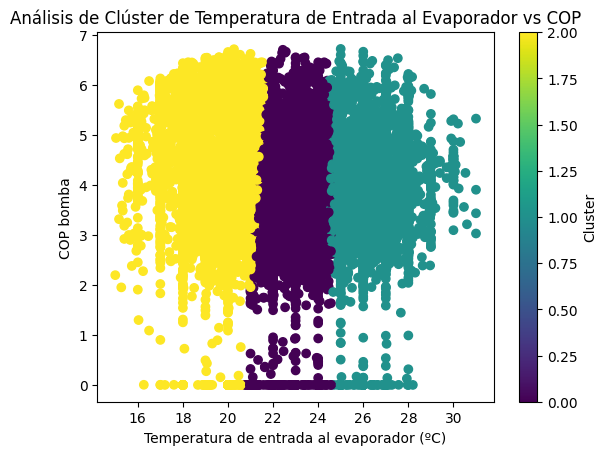

In [14]:
# Clusters entre T ent eva y COP bba 

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd


# y que 'T_ent_evaporador' y 'COP' son las columnas de tu interés

# Extraer las características para el análisis de clúster
X = df[['T ent. evaporador bomba (ºC)', 'COP bomba']]

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Predecir los clústeres
labels = kmeans.labels_


df['Cluster'] = labels

# Graficar los clústeres
plt.scatter(df['T ent. evaporador bomba (ºC)'], df['COP bomba'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Temperatura de entrada al evaporador (ºC)')
plt.ylabel('COP bomba')
plt.title('Análisis de Clúster de Temperatura de Entrada al Evaporador vs COP')
plt.colorbar(label='Cluster')
plt.show()
